<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

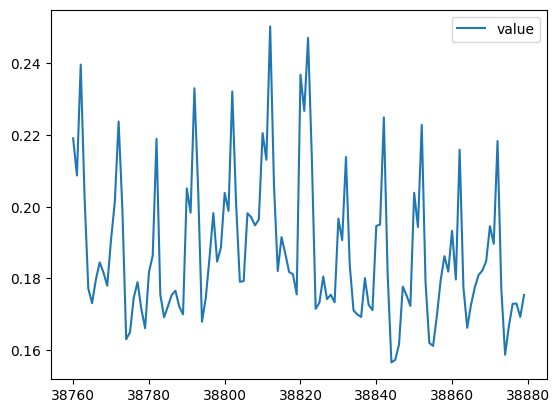

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 5
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_617581/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 13.024005653739673 %
smape 9.78058048202629 %
smape 9.41845867978899 %
smape 9.205063875132833 %
smape 9.18861401054943 %
smape 9.132427459048946 %
smape 9.036921894951174 %
smape 9.012411409302763 %
smape 9.013690394267702 %
smape 9.030779018475299 %
smape 9.058368751092962 %
smape 9.032645761443858 %
smape 9.013502956830967 %
smape 9.13091281526967 %
smape 9.147551069744148 %
smape 9.053895893065553 %
smape 8.905273473750778 %
smape 8.941691454652458 %
smape 8.950451695256763 %
smape 8.980216522488679 %
smape 9.086254552790992 %
smape 8.97954663948009 %
smape 8.782070676921403 %
smape 8.778432380647686 %
smape 8.825640471009482 %
smape 8.787106713443471 %
smape 8.716269473583377 %
smape 8.776400293174543 %
smape 8.85528184909221 %
smape 8.77958056130256 %
smape 8.787946831761746 %
smape 8.808456632303216 %
smape 8.727876495199594 %
smape 8.752786867451249 %
smape 8.75827556508675 %
smape 8.711899299806323 %
smape 8.74379828833697 %
smape 8.807893013745023 %
smape 8.701982011049

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.25503878541894665 %
SMAPE 5.261865044813021 %
SMAPE 0.7066932454654307 %
SMAPE 0.2840095873980317 %
SMAPE 0.7142570134969901 %
SMAPE 0.03542940364309288 %
SMAPE 1.1761143065132273 %
SMAPE 0.05489649846595057 %
SMAPE 1.2815303876850521 %
SMAPE 0.2181463525048457 %
SMAPE 0.412593524573822 %
SMAPE 0.33269520370595274 %
SMAPE 0.1282733136558818 %
SMAPE 0.37921922604891733 %
SMAPE 0.9667329429478286 %
SMAPE 1.5042921452841256 %
SMAPE 1.268233183385746 %
SMAPE 4.338193140320072 %
SMAPE 1.0763264654603972 %
SMAPE 0.16223910223570215 %
SMAPE 1.159246452474008 %
SMAPE 0.6207901134603162 %
SMAPE 2.0068026875160285 %
SMAPE 0.28677938266582714 %
SMAPE 1.8640893098709057 %
SMAPE 2.30746238192296 %
SMAPE 0.28939664789686503 %
SMAPE 1.386757632230001 %
SMAPE 1.6717653506857457 %
SMAPE 0.45918214483378955 %
SMAPE 0.17063522206808557 %
SMAPE 0.4186044537724456 %
SMAPE 0.23904084719106322 %
SMAPE 0.9786503484974673 %
SMAPE 0.37041304400918307 %
SMAPE 0.3032321297132512 %
SMAPE 0.7349080249186954

SMAPE 1.1234498793746752 %
SMAPE 0.6964688522548386 %
SMAPE 0.4686499268336775 %
SMAPE 2.5614328732517606 %
SMAPE 0.19957714121005668 %
SMAPE 2.6982177584832243 %
SMAPE 0.2818841751322907 %
SMAPE 0.09473873468778038 %
SMAPE 0.14389668683543277 %
SMAPE 0.5926993002212839 %
SMAPE 0.6722125293090357 %
SMAPE 0.7387793593588867 %
SMAPE 9.806009574531345 %
SMAPE 3.0911113614565693 %
SMAPE 1.8008184618965968 %
SMAPE 4.036967640036892 %
SMAPE 0.43414494359058153 %
SMAPE 0.4376526480918983 %
SMAPE 0.47758309107302926 %
SMAPE 1.194085369518234 %
SMAPE 0.15627409759781585 %
SMAPE 0.09061414187772243 %
SMAPE 0.8106772464743698 %
SMAPE 0.5776370730009148 %
SMAPE 0.26647995635858024 %
SMAPE 1.1894069731570198 %
SMAPE 1.4096529510006803 %
SMAPE 1.3676149329039617 %
SMAPE 0.7539169371302705 %
SMAPE 2.711074322785862 %
SMAPE 1.5722092896467075 %
SMAPE 0.5468330396470265 %
SMAPE 0.12796696434270416 %
SMAPE 0.12356342096632035 %
SMAPE 0.5766563579018111 %
SMAPE 0.08170246555891936 %
SMAPE 0.0815004331770

SMAPE 0.2763951763045043 %
SMAPE 0.13913512269573403 %
SMAPE 0.3247745774779105 %
SMAPE 0.8566692693875666 %
SMAPE 0.6029335001901472 %
SMAPE 1.434122874699824 %
SMAPE 0.8141565813443776 %
SMAPE 0.15116796620714013 %
SMAPE 0.48766051164352575 %
SMAPE 0.6360699882498011 %
SMAPE 0.2347661719140888 %
SMAPE 0.6040196860778337 %
SMAPE 0.11973087397927884 %
SMAPE 0.8616522134070692 %
SMAPE 0.4610267055013538 %
SMAPE 0.18865118358735344 %
SMAPE 0.4405563278269255 %
SMAPE 0.5556390990295768 %
SMAPE 0.8076172472719918 %
SMAPE 0.22854467662364186 %
SMAPE 0.44462414852387155 %
SMAPE 0.72241412448966 %
SMAPE 2.054074137326097 %
SMAPE 0.55361412441016 %
SMAPE 0.8017765647546184 %
SMAPE 0.4905985602636065 %
SMAPE 0.5283921685841051 %
SMAPE 0.08096269852069327 %
SMAPE 0.28639008154260637 %
SMAPE 0.8673615222087393 %
SMAPE 0.38809582754129224 %
SMAPE 0.46296218706606856 %
SMAPE 0.03587563888868317 %
SMAPE 0.4800306178240134 %
SMAPE 0.1806010319996858 %
SMAPE 0.18665008292009588 %
SMAPE 0.8971308642113

SMAPE 0.05805783265032006 %
SMAPE 0.727184763493824 %
SMAPE 0.536553321449901 %
SMAPE 0.6346945936902557 %
SMAPE 0.3042314805340993 %
SMAPE 0.09539078560584358 %
SMAPE 0.053514255054778914 %
SMAPE 0.1564047098527226 %
SMAPE 0.25754509603893894 %
SMAPE 0.19093940081438632 %
SMAPE 0.5945703083969534 %
SMAPE 0.4140523562014096 %
SMAPE 0.9035473042802096 %
SMAPE 0.3583839120910852 %
SMAPE 0.10486760699131993 %
SMAPE 0.12304748117708186 %
SMAPE 1.7794062520691796 %
SMAPE 0.2841552757681711 %
SMAPE 0.10737858858465188 %
SMAPE 0.03923815764119354 %
SMAPE 0.03972810304185259 %
SMAPE 0.3590467220856226 %
SMAPE 0.6012567502821184 %
SMAPE 0.3502990709043843 %
SMAPE 0.111935358095252 %
SMAPE 0.12244619079228869 %
SMAPE 0.9612195903910106 %
SMAPE 0.07927671239258416 %
SMAPE 0.244176580152498 %
SMAPE 0.36337378984353563 %
SMAPE 0.2656073422094778 %
SMAPE 0.3200404780836834 %
SMAPE 0.5971100881351958 %
SMAPE 1.4485556780027764 %
SMAPE 0.6524213084503572 %
SMAPE 0.2345108389599773 %
SMAPE 0.2596564606

SMAPE 0.14883787846383711 %
SMAPE 1.2647457982930064 %
SMAPE 0.2896991409579641 %
SMAPE 0.6801332437194105 %
SMAPE 0.08967034176566813 %
SMAPE 0.07414439756803404 %
SMAPE 0.6387792994506754 %
SMAPE 0.4755418096240191 %
SMAPE 0.7317163302832341 %
SMAPE 0.3611302328399688 %
SMAPE 0.08300217344321936 %
SMAPE 0.23245378589945176 %
SMAPE 0.20374274528262507 %
SMAPE 0.10188555936838384 %
SMAPE 0.9006475582234827 %
SMAPE 1.3972799652665344 %
SMAPE 0.030148607795126736 %
SMAPE 0.385807871212819 %
SMAPE 0.24598476461324026 %
SMAPE 0.07943425553457928 %
SMAPE 0.1379817549022846 %
SMAPE 0.05534667114920921 %
SMAPE 0.31317939410655526 %
SMAPE 0.20087871747159625 %
SMAPE 0.7913453777528048 %
SMAPE 0.6543339091804228 %
SMAPE 0.26690770349978266 %
SMAPE 0.09339339460359497 %
SMAPE 0.2863048149242786 %
SMAPE 0.5826132585919481 %
SMAPE 0.2710579492159013 %
SMAPE 0.18665130734007107 %
SMAPE 0.5364067699338193 %
SMAPE 0.5106766342141782 %
SMAPE 0.8273330481406447 %
SMAPE 1.8061928948864079 %
SMAPE 0.0730

SMAPE 0.3172752124928593 %
SMAPE 0.4008984290217086 %
SMAPE 2.215621241371082 %
SMAPE 0.1991349439285841 %
SMAPE 0.07390272437351086 %
SMAPE 0.24850881939892133 %
SMAPE 0.17639183862047503 %
SMAPE 0.04895007330560474 %
SMAPE 0.1290181340482377 %
SMAPE 0.4283855603534903 %
SMAPE 0.4146775336585052 %
SMAPE 0.47843711307723424 %
SMAPE 0.4723052708095565 %
SMAPE 0.1413490292034112 %
SMAPE 0.1446216276440282 %
SMAPE 0.2601024210248397 %
SMAPE 0.8398963256895512 %
SMAPE 0.2698024576784519 %
SMAPE 0.13088071780657629 %
SMAPE 0.34382085009747243 %
SMAPE 1.5690634880138534 %
SMAPE 0.32527506417727636 %
SMAPE 0.05638172035361322 %
SMAPE 0.7851670413948781 %
SMAPE 1.1010392118041636 %
SMAPE 0.3208923940155728 %
SMAPE 0.4912468123286544 %
SMAPE 0.18519954685666562 %
SMAPE 0.9051445698169118 %
SMAPE 0.370496399614467 %
SMAPE 0.5348666094068903 %
SMAPE 0.46553866432827823 %
SMAPE 0.5780770990963902 %
SMAPE 0.18811869456294517 %
SMAPE 0.3807575514219934 %
SMAPE 0.4850783241456611 %
SMAPE 0.3483801694

SMAPE 0.8009519661109153 %
SMAPE 0.3814198604441117 %
SMAPE 0.1001947742174707 %
SMAPE 0.35373135506779363 %
SMAPE 1.263888661382225 %
SMAPE 0.38325886457096203 %
SMAPE 1.676991304171679 %
SMAPE 0.08498712453001644 %
SMAPE 0.8894014892521227 %
SMAPE 0.0836556996755462 %
SMAPE 1.4351509801817883 %
SMAPE 1.637237826872024 %
SMAPE 0.5467353221588382 %
SMAPE 0.2483455175824929 %
SMAPE 0.4533946904541608 %
SMAPE 0.0934491820223684 %
SMAPE 0.8253000962868099 %
SMAPE 0.6967513528668405 %
SMAPE 0.5959666591800783 %
SMAPE 1.3947294598501685 %
SMAPE 0.41515905950859633 %
SMAPE 0.09115775682600713 %
SMAPE 0.42818887819674956 %
SMAPE 0.5757943052667542 %
SMAPE 2.1451908506614927 %
SMAPE 1.3182477453447063 %
SMAPE 0.44768192420133346 %
SMAPE 0.0629470406438486 %
SMAPE 12.92988218262326 %
SMAPE 8.847519881863263 %
SMAPE 1.2173363787078415 %
SMAPE 2.7571976374347287 %
SMAPE 0.10211132207314222 %
SMAPE 1.1499351812508394 %
SMAPE 0.09284263186418684 %
SMAPE 0.7819885506687569 %
SMAPE 0.23434507554839 %

SMAPE 0.0402033627747187 %
SMAPE 0.7589965405059047 %
SMAPE 0.06135385451716502 %
SMAPE 1.3354111356579779 %
SMAPE 0.3127033562914221 %
SMAPE 0.45399891246279367 %
SMAPE 0.8299092112920334 %
SMAPE 0.5826473877368699 %
SMAPE 0.7082459007027637 %
SMAPE 0.4503770191786316 %
SMAPE 1.8523553888844617 %
SMAPE 0.04710567540928423 %
SMAPE 4.0148815559150535 %
SMAPE 6.1753601968084695 %
SMAPE 4.460981077179895 %
SMAPE 0.06893566211738289 %
SMAPE 0.6414820670397603 %
SMAPE 0.08556897889866377 %
SMAPE 0.7250906782633137 %
SMAPE 0.03896004731359426 %
SMAPE 0.03861716499227441 %
SMAPE 0.1324912563172802 %
SMAPE 0.37911217490182025 %
SMAPE 0.4137583899610036 %
SMAPE 0.1883921397748054 %
SMAPE 0.7134677500689577 %
SMAPE 0.2693170395850757 %
SMAPE 0.4221325152637973 %
SMAPE 0.14162896816014836 %
SMAPE 0.04320457038920722 %
SMAPE 0.12430721619466566 %
SMAPE 0.06371958622185048 %
SMAPE 0.6357022617521579 %
SMAPE 1.5900243315973057 %
SMAPE 0.2301319100152739 %
SMAPE 1.348640048749985 %
SMAPE 0.7344217857

SMAPE 2.010047565858116 %
SMAPE 0.18380154024453077 %
SMAPE 0.9733890991055887 %
SMAPE 0.23045319838729483 %
SMAPE 0.0365228901543162 %
SMAPE 0.13715391694847767 %
SMAPE 0.9617562015482689 %
SMAPE 0.24680564652828704 %
SMAPE 0.4169149410966497 %
SMAPE 0.3454645234792224 %
SMAPE 0.22531938025258572 %
SMAPE 0.057031548913073486 %
SMAPE 7.187584596918896 %
SMAPE 4.061341447279119 %
SMAPE 0.14166368747328306 %
SMAPE 0.3388819300707837 %
SMAPE 1.0582316118749304 %
SMAPE 2.1290270703772904 %
SMAPE 0.26706674317028956 %
SMAPE 2.570839865664311 %
SMAPE 0.9560904647987627 %
SMAPE 0.6759096607825086 %
SMAPE 3.211894471431151 %
SMAPE 1.0178276786524947 %
SMAPE 0.06391698422885383 %
SMAPE 0.08305155666948849 %
SMAPE 0.3528349892826057 %
SMAPE 0.9770954788764356 %
SMAPE 3.4209454444608127 %
SMAPE 0.9194892050636554 %
SMAPE 0.11829521260665389 %
SMAPE 1.7646849014627148 %
SMAPE 0.9226680457522889 %
SMAPE 2.7249623194365995 %
SMAPE 0.326405866641835 %
SMAPE 0.8144353773145667 %
SMAPE 1.60240866986532

SMAPE 0.1857789468467672 %
SMAPE 0.10438022437597283 %
SMAPE 0.34925363856746117 %
SMAPE 0.050850717591828236 %
SMAPE 1.2649288398351928 %
SMAPE 0.07217736141546993 %
SMAPE 0.09606143885844176 %
SMAPE 0.33219710758066867 %
SMAPE 1.1599823983106035 %
SMAPE 0.2711510627896132 %
SMAPE 1.2874376843310529 %
SMAPE 0.3106102679474816 %
SMAPE 0.5023901006843516 %
SMAPE 0.9552281660635344 %
SMAPE 0.4864434851006081 %
SMAPE 1.9243375175810797 %
SMAPE 0.09047274236763769 %
SMAPE 0.04346237531558472 %
SMAPE 0.7721614920128559 %
SMAPE 0.7970210273792873 %
SMAPE 0.22955320703169946 %
SMAPE 1.4519035006924241 %
SMAPE 0.23725467786243826 %
SMAPE 1.6361182745313272 %
SMAPE 1.1975573291347246 %
SMAPE 3.4635537633967033 %
SMAPE 0.03827362306401483 %
SMAPE 0.329409688951273 %
SMAPE 2.1367984136213636 %
SMAPE 0.3719332438458878 %
SMAPE 0.035606577732323785 %
SMAPE 1.992805236168351 %
SMAPE 1.4629253909301951 %
SMAPE 0.1079543925852704 %
SMAPE 0.2194528043291939 %
SMAPE 0.42360345646557107 %
SMAPE 0.2601177

SMAPE 0.5058202077707392 %
SMAPE 0.1258513282475633 %
SMAPE 0.11626372045137146 %
SMAPE 6.8389368733624 %
SMAPE 0.4497595455241026 %
SMAPE 0.13793004325073355 %
SMAPE 6.959243140605395 %
SMAPE 0.8152629257674562 %
SMAPE 0.5772096574833085 %
SMAPE 0.04199882581633574 %
SMAPE 0.3595085626384389 %
SMAPE 3.013275052919198 %
SMAPE 0.07253032786866243 %
SMAPE 7.161566609051079 %
SMAPE 0.7487425837873616 %
SMAPE 0.36091437049867636 %
SMAPE 4.088384253685945 %
SMAPE 0.6005625093293929 %
SMAPE 0.876566868335516 %
SMAPE 1.0887131786803366 %
SMAPE 0.23988561236348002 %
SMAPE 0.08384376457433973 %
SMAPE 0.24749842051278392 %
SMAPE 3.0311208556886413 %
SMAPE 0.03474763519852786 %
SMAPE 2.74605324640288 %
SMAPE 0.6210637041504015 %
SMAPE 0.7442720126005042 %
SMAPE 0.8973895082453964 %
SMAPE 0.2682630967705961 %
SMAPE 0.04399030233207668 %
SMAPE 0.12284917382999083 %
SMAPE 0.3828998986764418 %
SMAPE 3.12070675236464 %
SMAPE 0.03042161736098592 %
SMAPE 0.7515285949848476 %
SMAPE 0.05177112074397883 %


SMAPE 0.3517489969510166 %
SMAPE 0.9335719148593854 %
SMAPE 0.771153674326797 %
SMAPE 0.9193219124063035 %
SMAPE 0.6881460486799824 %
SMAPE 0.2891499249001299 %
SMAPE 0.1276675717552962 %
SMAPE 2.322780051295922 %
SMAPE 2.1769122497298667 %
SMAPE 0.5191939130315859 %
SMAPE 0.303247925034384 %
SMAPE 1.705716248958197 %
SMAPE 0.1430959696942864 %
SMAPE 0.3283211362322618 %
SMAPE 0.15866192920020694 %
SMAPE 1.7414063999956395 %
SMAPE 0.12623637182559833 %
SMAPE 0.8893939369008875 %
SMAPE 0.07652508602313901 %
SMAPE 1.3050180958089186 %
SMAPE 0.048513087833043755 %
SMAPE 2.45341097833807 %
SMAPE 0.14079662638062018 %
SMAPE 1.7381311968747468 %
SMAPE 0.5721363414636471 %
SMAPE 0.7884988141195209 %
SMAPE 3.4452830090958746 %
SMAPE 1.00263100149823 %
SMAPE 0.07825155983118748 %
SMAPE 0.8556463676743533 %
SMAPE 0.098718506339992 %
SMAPE 0.6772697077867633 %
SMAPE 0.04982108223646264 %
SMAPE 0.5052387732939678 %
SMAPE 1.0151101858828042 %
SMAPE 2.6309319703177607 %
SMAPE 0.046051594020127595 %


SMAPE 0.8734726384896021 %
SMAPE 2.0093985501953284 %
SMAPE 4.70946680335328 %
SMAPE 0.2021793601347781 %
SMAPE 0.5055147028506326 %
SMAPE 0.5958832907053875 %
SMAPE 0.10092978051761747 %
SMAPE 0.39074869333671813 %
SMAPE 0.1134732280987123 %
SMAPE 0.9155841318097373 %
SMAPE 0.05685238650926294 %
SMAPE 0.026362359346421727 %
SMAPE 0.7936384372546854 %
SMAPE 0.45121898324714493 %
SMAPE 0.6066561561246999 %
SMAPE 0.01404286205843164 %
SMAPE 0.1768648537754416 %
SMAPE 0.38336324204919947 %
SMAPE 0.29462187157753306 %
SMAPE 0.11137740318190481 %
SMAPE 0.4409842522957206 %
SMAPE 4.577131548343459 %
SMAPE 0.33558035607711645 %
SMAPE 1.7176892577802791 %
SMAPE 1.1258245604576587 %
SMAPE 2.0237064919201657 %
SMAPE 0.013096852339423037 %
SMAPE 0.929791973106262 %
SMAPE 0.4080972749247849 %
SMAPE 0.20563159339053527 %
SMAPE 0.0657140917895731 %
SMAPE 0.25335254958918085 %
SMAPE 0.10437498663122824 %
SMAPE 0.7256589173753127 %
SMAPE 0.03999784309644383 %
SMAPE 1.473167791562446 %
SMAPE 0.21303593

SMAPE 0.2216808220873645 %
SMAPE 0.5554475819751588 %
SMAPE 3.1523028012743453 %
SMAPE 1.9891654729835864 %
SMAPE 0.10650776255442906 %
SMAPE 1.2996441187524397 %
SMAPE 0.07004563873215375 %
SMAPE 0.24371928302116427 %
SMAPE 0.09123701828787034 %
SMAPE 0.08149372793400289 %
SMAPE 1.0633192938448701 %
SMAPE 0.029972351767355576 %
SMAPE 0.9930667587323114 %
SMAPE 1.0589960620054626 %
SMAPE 0.2329379135526324 %
SMAPE 0.2805710215416184 %
SMAPE 0.12970480546209728 %
SMAPE 0.2148315840337318 %
SMAPE 0.032394578600360546 %
SMAPE 0.09696774479630221 %
SMAPE 0.0679379363807584 %
SMAPE 0.8531757147684402 %
SMAPE 0.25338368355886587 %
SMAPE 0.30688006500986376 %
SMAPE 0.400867026807191 %
SMAPE 0.5866446538730088 %
SMAPE 0.22252177154234687 %
SMAPE 0.7232430963267689 %
SMAPE 0.06833794731868181 %
SMAPE 0.1334751207626823 %
SMAPE 0.13179841799615133 %
SMAPE 0.019439987604044973 %
SMAPE 0.1800008004393021 %
SMAPE 0.07927933785708774 %
SMAPE 0.3730539998856557 %
SMAPE 0.4581518174127268 %
SMAPE 0.31

SMAPE 0.07616211159677277 %
SMAPE 0.13485256356484854 %
SMAPE 0.14589109481153173 %
SMAPE 0.4282981768226364 %
SMAPE 0.17355631872101185 %
SMAPE 1.0883101139961582 %
SMAPE 0.3693882722559465 %
SMAPE 0.23056493601689 %
SMAPE 0.07163052520365909 %
SMAPE 0.037023258477347554 %
SMAPE 0.13269923663119698 %
SMAPE 0.34818428000789936 %
SMAPE 0.07899461124679874 %
SMAPE 0.05022948782789172 %
SMAPE 0.03490930132198855 %
SMAPE 0.11908046593646303 %
SMAPE 0.2852985025365342 %
SMAPE 0.3678980053446139 %
SMAPE 0.023620964489509788 %
SMAPE 0.3346791479825697 %
SMAPE 0.30422758177621745 %
SMAPE 0.14738245922399074 %
SMAPE 0.4606799321268226 %
SMAPE 0.22942407505092888 %
SMAPE 0.526192204050858 %
SMAPE 1.2774954448505014 %
SMAPE 0.8287941720166145 %
SMAPE 0.14036648457749834 %
SMAPE 0.09714246403723337 %
SMAPE 0.1658604952672249 %
SMAPE 0.31000983918102065 %
SMAPE 0.3699688724200314 %
SMAPE 1.6126387795375194 %
SMAPE 0.33757551918279205 %
SMAPE 3.0363303584454115 %
SMAPE 0.3880947764725988 %
SMAPE 0.2

SMAPE 4.454524954271619 %
SMAPE 0.5287927693998427 %
SMAPE 9.108050823037047 %
SMAPE 0.08255109092897328 %
SMAPE 0.2976483304834119 %
SMAPE 3.429980987973977 %
SMAPE 0.1659524097776739 %
SMAPE 2.332135714652395 %
SMAPE 4.4288286574956715 %
SMAPE 1.187446080672089 %
SMAPE 0.1572351126292233 %
SMAPE 0.12627212329789472 %
SMAPE 0.029014126533184026 %
SMAPE 1.2057658381963847 %
SMAPE 0.10540517357367207 %
SMAPE 0.7032753140940429 %
SMAPE 0.18171156218977558 %
SMAPE 2.174031891303457 %
SMAPE 0.2010004594367274 %
SMAPE 0.6931804746072885 %
SMAPE 1.451042516331654 %
SMAPE 0.01953501621551368 %
SMAPE 0.1441576570541656 %
SMAPE 0.7269821119003268 %
SMAPE 0.4571659648845526 %
SMAPE 2.6543559127567278 %
SMAPE 0.7255056970388978 %
SMAPE 0.7667628171365095 %
SMAPE 0.1893006715727097 %
SMAPE 0.8723034723807359 %
SMAPE 1.6530631883797469 %
SMAPE 1.1258085649869827 %
SMAPE 0.15637009661077172 %
SMAPE 1.5667847458098552 %
SMAPE 6.1306818404991645 %
SMAPE 0.27642918811397976 %
SMAPE 0.583151115039982 %


SMAPE 1.5693581267405534 %
SMAPE 0.037595081346808 %
SMAPE 0.545497083176997 %
SMAPE 0.4693828545332508 %
SMAPE 0.4826352886843779 %
SMAPE 0.8922518355047941 %
SMAPE 1.1411220204490746 %
SMAPE 0.2941069431599317 %
SMAPE 0.10348662450269329 %
SMAPE 0.19329288478365925 %
SMAPE 0.2055848832984566 %
SMAPE 0.21329605407481722 %
SMAPE 0.04351220986541193 %
SMAPE 1.2061730434761557 %
SMAPE 0.6280424986034632 %
SMAPE 0.8997076217119683 %
SMAPE 0.3619415477223811 %
SMAPE 0.28516429975752544 %
SMAPE 0.2929247452665322 %
SMAPE 0.270630115731592 %
SMAPE 0.6364924651004458 %
SMAPE 0.03998651207552939 %
SMAPE 0.231879906121776 %
SMAPE 0.6562988071295877 %
SMAPE 1.0149228677109932 %
SMAPE 8.166217423975468 %
SMAPE 4.924755353335058 %
SMAPE 0.8892893846059451 %
SMAPE 0.3509451494746827 %
SMAPE 1.4178217214139295 %
SMAPE 1.4996490443627408 %
SMAPE 2.831790154566079 %
SMAPE 0.9036977249634219 %
SMAPE 1.2381722318377797 %
SMAPE 0.3974901413714633 %
SMAPE 0.8412502503888389 %
SMAPE 0.04404081386064718 %
S

SMAPE 0.5732087315045646 %
SMAPE 0.4399817723351589 %
SMAPE 0.02833302830640605 %
SMAPE 0.33612301185576143 %
SMAPE 0.7070652465376952 %
SMAPE 1.0246036147873383 %
SMAPE 0.22040366548208112 %
SMAPE 0.11247398210605297 %
SMAPE 0.3502504209734525 %
SMAPE 0.13130119206704194 %
SMAPE 0.23255902228993364 %
SMAPE 0.27901686207405874 %
SMAPE 0.04285723661632801 %
SMAPE 1.8179469874012284 %
SMAPE 0.4734485138131958 %
SMAPE 0.5078571341647375 %
SMAPE 0.09191843928533672 %
SMAPE 1.7117866193184454 %
SMAPE 0.6160094383108117 %
SMAPE 0.30510053931539005 %
SMAPE 0.24281101776250583 %
SMAPE 0.5241797170204165 %
SMAPE 1.0562861233211152 %
SMAPE 0.05382279364130227 %
SMAPE 0.26941846058889496 %
SMAPE 0.25063386534748133 %
SMAPE 0.5523611449134478 %
SMAPE 2.7073392110760324 %
SMAPE 0.6314505170812481 %
SMAPE 0.14333475195735446 %
SMAPE 0.04273286777674912 %
SMAPE 0.17773166195316747 %
SMAPE 0.9235604088207765 %
SMAPE 1.558234847806034 %
SMAPE 0.4120981716732785 %
SMAPE 0.06577248545966086 %
SMAPE 0.584

SMAPE 2.2688985277891334 %
SMAPE 1.6195786839252835 %
SMAPE 0.32885495745040316 %
SMAPE 0.6883007510132302 %
SMAPE 0.3920694711741817 %
SMAPE 0.534074893834827 %
SMAPE 0.9702821457403843 %
SMAPE 0.10487780499374821 %
SMAPE 0.1971952334292837 %
SMAPE 0.31263054176554306 %
SMAPE 1.297479614340773 %
SMAPE 1.2108289190400683 %
SMAPE 0.2678925878217342 %
SMAPE 0.23415377356741374 %
SMAPE 0.5827049356330463 %
SMAPE 0.16998915849580953 %
SMAPE 0.48046080229323707 %
SMAPE 0.24305967124928432 %
SMAPE 0.5862368780890392 %
SMAPE 0.3661532279846398 %
SMAPE 0.07400536739169183 %
SMAPE 0.7219470340487533 %
SMAPE 1.4948465686402415 %
SMAPE 0.38169682971602015 %
SMAPE 0.10076429028310939 %
SMAPE 0.33252490588529326 %
SMAPE 0.15400337508981465 %
SMAPE 3.5082938210252905 %
SMAPE 0.2068838356303786 %
SMAPE 1.5719219805232567 %
SMAPE 2.071288436076429 %
SMAPE 0.3053617296046127 %
SMAPE 0.4077367781856083 %
SMAPE 0.4493396245143231 %
SMAPE 0.07249377411650926 %
SMAPE 2.4663205683548313 %
SMAPE 0.5658336951

SMAPE 3.4424345894549333 %
SMAPE 0.07832057229552447 %
SMAPE 0.02815377485262616 %
SMAPE 2.2770753341246746 %
SMAPE 2.0454202386717952 %
SMAPE 0.6475629806809593 %
SMAPE 3.63295515433856 %
SMAPE 0.35970448599437077 %
SMAPE 0.20309162270154957 %
SMAPE 0.6091571469987684 %
SMAPE 0.28638547189166275 %
SMAPE 0.3261213363803108 %
SMAPE 0.2692155440549868 %
SMAPE 0.9640395025753605 %
SMAPE 0.16977274860823854 %
SMAPE 0.9658219491066121 %
SMAPE 1.8162683354748879 %
SMAPE 0.704784646920416 %
SMAPE 0.9281015465830933 %
SMAPE 0.5887301463881158 %
SMAPE 2.2397647548859823 %
SMAPE 0.013894093839553534 %
SMAPE 0.3271159185828765 %
SMAPE 0.3496389775177704 %
SMAPE 0.3965424172783969 %
SMAPE 0.2524890930496895 %
SMAPE 0.8863868778953475 %
SMAPE 0.13128251933085267 %
SMAPE 0.7869790869781355 %
SMAPE 0.46873091834095254 %
SMAPE 0.10634290916766531 %
SMAPE 0.7166868058041018 %
SMAPE 0.12561590255972988 %
SMAPE 0.4290159269298783 %
SMAPE 0.3098979768456047 %
SMAPE 0.17340664343623757 %
SMAPE 0.1132010768

SMAPE 5.510417769663036 %
SMAPE 1.2955299183977331 %
SMAPE 2.165829213729012 %
SMAPE 1.2034220281293528 %
SMAPE 0.3909845685830078 %
SMAPE 1.4058490698465675 %
SMAPE 0.24435853469594807 %
SMAPE 0.7573992930622353 %
SMAPE 0.26679662108784896 %
SMAPE 0.31738231294366415 %
SMAPE 5.3831164248003915 %
SMAPE 2.464302578016941 %
SMAPE 1.4385676092097128 %
SMAPE 1.3097543218027567 %
SMAPE 0.4401840241880564 %
SMAPE 1.5520949937908881 %
SMAPE 1.6808685719370262 %
SMAPE 0.35081005375195673 %
SMAPE 1.768145573751099 %
SMAPE 0.03677974057058009 %
SMAPE 2.6224497154380515 %
SMAPE 1.9355779435518343 %
SMAPE 0.6831893641301576 %
SMAPE 1.247099254056593 %
SMAPE 0.4433923405222231 %
SMAPE 2.4321293607135885 %
SMAPE 0.04054579760443744 %
SMAPE 0.7391941990199484 %
SMAPE 0.7730242048579612 %
SMAPE 0.6801714468456339 %
SMAPE 0.5038805777930975 %
SMAPE 0.4956688352722267 %
SMAPE 1.6065511301871993 %
SMAPE 0.39920085769153957 %
SMAPE 0.14714967743566376 %
SMAPE 0.17763631562930016 %
SMAPE 0.3465331824027089

SMAPE 4.035703790461412 %
SMAPE 1.0015448276180905 %
SMAPE 0.1322481401668938 %
SMAPE 0.19137636867003494 %
SMAPE 1.4557382532439078 %
SMAPE 0.13679308336134 %
SMAPE 0.04249127051457435 %
SMAPE 0.03730258266961073 %
SMAPE 1.3404230101441499 %
SMAPE 3.6402170559922524 %
SMAPE 1.8069355979278043 %
SMAPE 0.1878754302742891 %
SMAPE 0.5204238728507562 %
SMAPE 0.06354947699946933 %
SMAPE 1.0204546512568413 %
SMAPE 0.923775571633314 %
SMAPE 0.41736728867283546 %
SMAPE 3.100065944068774 %
SMAPE 0.7789129971242801 %
SMAPE 2.413632028052234 %
SMAPE 2.807228790865338 %
SMAPE 0.02458604509634199 %
SMAPE 0.2023884724872005 %
SMAPE 1.618258079767429 %
SMAPE 0.46107023009244585 %
SMAPE 0.18643282416474705 %
SMAPE 0.05317586952878628 %
SMAPE 1.1159254935143679 %
SMAPE 0.04155753226496017 %
SMAPE 0.46672923053847626 %
SMAPE 0.22065441396443927 %
SMAPE 0.05528707515281894 %
SMAPE 0.7139967470666306 %
SMAPE 0.12975268188313294 %
SMAPE 0.3437020795818171 %
SMAPE 2.2126681263707724 %
SMAPE 0.43790575906393

SMAPE 0.7368097674184355 %
SMAPE 0.18415842753768175 %
SMAPE 1.4416082551579166 %
SMAPE 1.121526087372331 %
SMAPE 1.850465781222738 %
SMAPE 0.5895411903766217 %
SMAPE 0.6244248515840809 %
SMAPE 0.9318301129151224 %
SMAPE 4.841263391514076 %
SMAPE 0.20532307580106135 %
SMAPE 0.32423076416898766 %
SMAPE 3.1781907094336934 %
SMAPE 0.11260607238625653 %
SMAPE 2.310402275998058 %
SMAPE 1.5178654496394302 %
SMAPE 0.05164704196749881 %
SMAPE 4.709341107394721 %
SMAPE 0.33597477761941263 %
SMAPE 1.9515587640448757 %
SMAPE 3.010962135551381 %
SMAPE 0.2852337129413627 %
SMAPE 0.6723190084967428 %
SMAPE 1.181525220945332 %
SMAPE 2.118188439431833 %
SMAPE 1.3067881509623476 %
SMAPE 0.02346348983030566 %
SMAPE 0.046426001836834985 %
SMAPE 1.3158638930754023 %
SMAPE 0.7860076488061623 %
SMAPE 0.7775602207757402 %
SMAPE 0.13431360165407114 %
SMAPE 0.09989951696231714 %
SMAPE 0.021733113974732987 %
SMAPE 1.4567209113805575 %
SMAPE 0.9378358069623118 %
SMAPE 1.0330576980632031 %
SMAPE 0.520782963268629

SMAPE 0.9414693327116765 %
SMAPE 0.5135961608557409 %
SMAPE 2.382790037081577 %
SMAPE 2.046301900969411 %
SMAPE 0.05731497198453184 %
SMAPE 0.8443677126897454 %
SMAPE 4.139607447737944 %
SMAPE 0.22338471096099966 %
SMAPE 0.03207251428739255 %
SMAPE 1.2629765239653352 %
SMAPE 2.630040073710177 %
SMAPE 0.4905107067042991 %
SMAPE 0.8101097544467848 %
SMAPE 0.05395164252905715 %
SMAPE 0.26225340520704776 %
SMAPE 1.6448312545617227 %
SMAPE 1.0603350860355931 %
SMAPE 0.17353515689501364 %
SMAPE 0.23708046489505818 %
SMAPE 0.10081465853727421 %
SMAPE 1.1125484655121909 %
SMAPE 0.22242792143788392 %
SMAPE 0.46140213832183014 %
SMAPE 0.033955317326444856 %
SMAPE 1.6327857239539298 %
SMAPE 0.11575955214721033 %
SMAPE 0.3038586201846556 %
SMAPE 0.5636337029163769 %
SMAPE 1.1989815388624265 %
SMAPE 1.3881431567024265 %
SMAPE 1.7986004431113545 %
SMAPE 0.06639725773220562 %
SMAPE 0.040781478696771956 %
SMAPE 0.1294923988057235 %
SMAPE 0.5439641616458175 %
SMAPE 0.2814757854648633 %
SMAPE 1.20492136

SMAPE 0.15607052630980434 %
SMAPE 0.344615223006258 %
SMAPE 0.16436733083924082 %
SMAPE 1.1535983554308586 %
SMAPE 0.09893467767142285 %
SMAPE 0.33343722897257067 %
SMAPE 0.6131557239768881 %
SMAPE 0.11036928943963176 %
SMAPE 0.5086356099873228 %
SMAPE 0.41464984180674946 %
SMAPE 0.3184855719805455 %
SMAPE 3.3723715273954435 %
SMAPE 1.3459514617879904 %
SMAPE 3.7320425210491526 %
SMAPE 2.738717835916759 %
SMAPE 1.7509638947240094 %
SMAPE 0.9814565722217594 %
SMAPE 0.3244424835979771 %
SMAPE 0.15954562645492842 %
SMAPE 4.111090072750812 %
SMAPE 0.5867688712364725 %
SMAPE 0.46420217187551316 %
SMAPE 0.4783021318144165 %
SMAPE 0.6807224217519945 %
SMAPE 0.07562047140663708 %
SMAPE 0.031512485755229136 %
SMAPE 0.052812842733146674 %
SMAPE 0.07483557489263148 %
SMAPE 0.05779608425655169 %
SMAPE 0.3007532872252341 %
SMAPE 1.0686029132211843 %
SMAPE 1.5281194075214444 %
SMAPE 0.062039540165869766 %
SMAPE 0.07802854933369474 %
SMAPE 0.5039037624192133 %
SMAPE 1.4247977481063572 %
SMAPE 0.98245

SMAPE 0.0703051943914943 %
SMAPE 2.6818591121191275 %
SMAPE 2.0498941256373655 %
SMAPE 0.06331564183301452 %
SMAPE 2.3204355987909366 %
SMAPE 0.18296132956606925 %
SMAPE 0.09101804847250605 %
SMAPE 5.626136909457273 %
SMAPE 0.28455504211524385 %
SMAPE 1.0425922632880429 %
SMAPE 0.4978251137507641 %
SMAPE 1.133782695955233 %
SMAPE 2.7831075034015953 %
SMAPE 1.4764363094218425 %
SMAPE 0.491587762178142 %
SMAPE 0.9167880466757197 %
SMAPE 0.5263319693904123 %
SMAPE 0.026132756123843137 %
SMAPE 2.348169152845003 %
SMAPE 7.242611890877015 %
SMAPE 2.170996128621482 %
SMAPE 5.156026166761876 %
SMAPE 0.2592318255642567 %
SMAPE 0.6141584429725526 %
SMAPE 0.24755864896491173 %
SMAPE 1.9944453397332609 %
SMAPE 0.06435981891581832 %
SMAPE 0.17725378143177295 %
SMAPE 2.0672022633225424 %
SMAPE 0.20873704461610035 %
SMAPE 0.41896960530175426 %
SMAPE 0.45133642765176774 %
SMAPE 0.28940279642120004 %
SMAPE 2.62486833181174 %
SMAPE 0.13714805580275424 %
SMAPE 0.48539444858852226 %
SMAPE 0.12126347610185

SMAPE 1.6306352176102337 %
SMAPE 0.8005013292677176 %
SMAPE 0.9256107635483204 %
SMAPE 0.9067538790623075 %
SMAPE 0.22620700441393637 %
SMAPE 0.04742877752232744 %
SMAPE 0.03742197566634786 %
SMAPE 0.2311649966868572 %
SMAPE 0.14165969055511596 %
SMAPE 0.3154843759293726 %
SMAPE 0.2738881691129791 %
SMAPE 0.2400072625256939 %
SMAPE 0.8946050928589102 %
SMAPE 0.5579276263506472 %
SMAPE 0.12059735536604421 %
SMAPE 0.9219507401685405 %
SMAPE 0.39066515308149974 %
SMAPE 0.04758860158472089 %
SMAPE 0.09759527162577797 %
SMAPE 1.7012787829191893 %
SMAPE 0.06221294107513131 %
SMAPE 2.2423375509098378 %
SMAPE 0.7597118156061242 %
SMAPE 0.20082307984768022 %
SMAPE 1.7250691198569257 %
SMAPE 0.0614293758749227 %
SMAPE 0.8684034175603301 %
SMAPE 0.6088713365279546 %
SMAPE 0.06019448117331194 %
SMAPE 0.15019832067912375 %
SMAPE 0.22375132427987413 %
SMAPE 1.3849597126718436 %
SMAPE 0.02167192711840471 %
SMAPE 0.3313379934643308 %
SMAPE 0.2465417071525735 %
SMAPE 0.20757580903409692 %
SMAPE 0.27214

SMAPE 0.1162052469092032 %
SMAPE 0.2883334240523254 %
SMAPE 0.05959606551414254 %
SMAPE 0.11331797851653393 %
SMAPE 0.020603679767873473 %
SMAPE 0.29707479406852144 %
SMAPE 0.8074436366487134 %
SMAPE 0.16903214892954566 %
SMAPE 0.03499320334594813 %
SMAPE 0.10468730065895215 %
SMAPE 0.0771959939493172 %
SMAPE 0.38745500821096357 %
SMAPE 0.2926565474513154 %
SMAPE 0.6672545467363307 %
SMAPE 0.12809237698365905 %
SMAPE 0.06742798838786257 %
SMAPE 7.624234815128148 %
SMAPE 4.346166312787204 %
SMAPE 0.518985575273291 %
SMAPE 1.6600040712655755 %
SMAPE 0.10768820638122634 %
SMAPE 0.5354787676355954 %
SMAPE 1.3891077980842965 %
SMAPE 0.401990466225584 %
SMAPE 0.16053843778405508 %
SMAPE 0.2987009169492012 %
SMAPE 0.15223272064031335 %
SMAPE 0.7782578631608885 %
SMAPE 1.630943770347585 %
SMAPE 0.037372213045614444 %
SMAPE 0.11651541020773948 %
SMAPE 0.11808051377147422 %
SMAPE 1.3856695494469022 %
SMAPE 0.5832351486146763 %
SMAPE 0.12369258549756523 %
SMAPE 0.20215998794265033 %
SMAPE 0.54213

SMAPE 11.697262912988663 %
SMAPE 0.8288964085149928 %
SMAPE 5.393733528791927 %
SMAPE 0.14167135602565395 %
SMAPE 0.12381131687970992 %
SMAPE 0.4621008752510533 %
SMAPE 0.25012269894250494 %
SMAPE 0.7074094694860378 %
SMAPE 0.034525446500992985 %
SMAPE 0.48161196807086526 %
SMAPE 0.8296586088290496 %
SMAPE 0.13751601593867235 %
SMAPE 1.1252971554131364 %
SMAPE 0.5100444495819829 %
SMAPE 0.17648107535342206 %
SMAPE 0.20597017875661547 %
SMAPE 0.25714408284278534 %
SMAPE 0.6239290445337247 %
SMAPE 0.4089400261541414 %
SMAPE 0.5399677950745172 %
SMAPE 0.1812469825822518 %
SMAPE 0.5321923477240489 %
SMAPE 0.6035154198270902 %
SMAPE 1.3254685880892794 %
SMAPE 0.15979574293942278 %
SMAPE 0.04748135340560111 %
SMAPE 0.48295780240368913 %
SMAPE 0.12165216818277713 %
SMAPE 0.32499493359318876 %
SMAPE 0.2672446101710193 %
SMAPE 0.45027512934052544 %
SMAPE 0.03810417153499657 %
SMAPE 0.5804110861984668 %
SMAPE 1.4486763651293586 %
SMAPE 0.24435996004501703 %
SMAPE 0.022331778694365312 %
SMAPE 0.2

SMAPE 0.48562595118619356 %
SMAPE 4.289709241478704 %
SMAPE 1.257294106705558 %
SMAPE 0.1488813048126758 %
SMAPE 5.922328823246062 %
SMAPE 8.051672365905688 %
SMAPE 3.2694953936952516 %
SMAPE 1.648396689153742 %
SMAPE 1.0154509023677747 %
SMAPE 4.032934239803581 %
SMAPE 0.21724414731033903 %
SMAPE 0.15011570790738915 %
SMAPE 0.24683434425692494 %
SMAPE 0.19222735010498582 %
SMAPE 2.934076089511109 %
SMAPE 2.238270815385931 %
SMAPE 0.22888984467132903 %
SMAPE 1.005500056391611 %
SMAPE 0.22938636380513347 %
SMAPE 0.21737556548850986 %
SMAPE 0.8339063697312666 %
SMAPE 4.18669079378833 %
SMAPE 1.5625931935146582 %
SMAPE 0.2985083085629867 %
SMAPE 0.27993747919208545 %
SMAPE 0.39856553272966266 %
SMAPE 2.005394496610279 %
SMAPE 1.0640800894034328 %
SMAPE 0.033885937065747385 %
SMAPE 1.781768626835401 %
SMAPE 0.11622826335360514 %
SMAPE 0.11471587235973857 %
SMAPE 2.2456531406473914 %
SMAPE 0.5769462431101147 %
SMAPE 3.9321241501311306 %
SMAPE 3.8588759757985827 %
SMAPE 0.5948303282175402 %


SMAPE 0.4277087569530522 %
SMAPE 0.7011311371090869 %
SMAPE 0.857797116398615 %
SMAPE 1.2697765099437675 %
SMAPE 0.0686449541572074 %
SMAPE 0.09313934923011402 %
SMAPE 1.0779761186386168 %
SMAPE 2.300454900807381 %
SMAPE 3.628539610112057 %
SMAPE 1.4988920692976535 %
SMAPE 0.42296215855640185 %
SMAPE 0.021376587299698713 %
SMAPE 0.02889096824128501 %
SMAPE 1.6627104606895955 %
SMAPE 0.3690310434285493 %
SMAPE 0.5000870329186 %
SMAPE 0.045456982251380396 %
SMAPE 3.779076567763696 %
SMAPE 0.07572971335684997 %
SMAPE 0.9980203428917777 %
SMAPE 0.328222748292319 %
SMAPE 0.6406803754889552 %
SMAPE 2.286617984233999 %
SMAPE 0.9538192913569219 %
SMAPE 0.6336441824241774 %
SMAPE 0.786199868112817 %
SMAPE 0.03653879493413115 %
SMAPE 1.4210205226308972 %
SMAPE 0.22218347817010908 %
SMAPE 1.1114415381853178 %
SMAPE 0.2455798099981621 %
SMAPE 0.9987161357266815 %
SMAPE 0.15326020234260795 %
SMAPE 0.12840135169244604 %
SMAPE 1.7859734624489647 %
SMAPE 4.804862135177245 %
SMAPE 0.8570617240961839 %


SMAPE 0.02709932553989347 %
SMAPE 0.9616897206492468 %
SMAPE 0.06834136733505147 %
SMAPE 0.283559587871423 %
SMAPE 0.40047133157565895 %
SMAPE 4.674412696826039 %
SMAPE 2.838416367651007 %
SMAPE 0.04705772776463846 %
SMAPE 0.23892415680666093 %
SMAPE 0.061036353762574436 %
SMAPE 1.8620690243751596 %
SMAPE 2.1566428635569537 %
SMAPE 0.01716286099167519 %
SMAPE 1.146315843991033 %
SMAPE 0.6323705975437406 %
SMAPE 1.0849851253806264 %
SMAPE 3.1074507766534225 %
SMAPE 1.7848678453156026 %
SMAPE 0.17689771179630043 %
SMAPE 0.112459742061219 %
SMAPE 0.03695621346787448 %
SMAPE 1.9564588438661303 %
SMAPE 0.19372752929120907 %
SMAPE 0.5597197629089123 %
SMAPE 0.05440332931948433 %
SMAPE 0.1802456617620578 %
SMAPE 0.23352566201697303 %
SMAPE 0.01904301583272172 %
SMAPE 0.23034516509665084 %
SMAPE 0.6181394351913241 %
SMAPE 0.5459209453333642 %
SMAPE 0.32549851207113534 %
SMAPE 2.1781431305025762 %
SMAPE 2.518898378657468 %
SMAPE 0.027596466755653637 %
SMAPE 1.2254752633564294 %
SMAPE 9.13705770

SMAPE 0.76942895735192 %
SMAPE 6.429083907976746 %
SMAPE 2.2036867589704343 %
SMAPE 1.8974602956632225 %
SMAPE 0.7695497769809663 %
SMAPE 1.4249923938823486 %
SMAPE 0.06911735009475706 %
SMAPE 0.9015241007682562 %
SMAPE 0.043603022524735024 %
SMAPE 3.1826132047681313 %
SMAPE 0.11806251580765091 %
SMAPE 0.19283347381042404 %
SMAPE 1.1978433597960247 %
SMAPE 0.9455214840354529 %
SMAPE 0.36036285354566644 %
SMAPE 1.9796588495537435 %
SMAPE 0.8765867371985224 %
SMAPE 0.6234434492725995 %
SMAPE 11.492568992078304 %
SMAPE 5.251253664493561 %
SMAPE 0.7781713462493371 %
SMAPE 0.10673557785548836 %
SMAPE 0.21031313485286776 %
SMAPE 2.155363649818355 %
SMAPE 2.362982753264305 %
SMAPE 20.146245278418064 %
SMAPE 0.6535130200827552 %
SMAPE 0.08180832803009253 %
SMAPE 0.3539628110429476 %
SMAPE 2.85506809335493 %
SMAPE 0.08455736044975026 %
SMAPE 1.1419640715321293 %
SMAPE 0.035603831297805755 %
SMAPE 1.1912725699082785 %
SMAPE 0.43952127449392714 %
SMAPE 2.5081510886375327 %
SMAPE 6.779678470680666

SMAPE 0.06415262583050207 %
SMAPE 2.062921607725457 %
SMAPE 1.0072491746395826 %
SMAPE 5.4791048037441215 %
SMAPE 8.168929770239629 %
SMAPE 2.3290671331742487 %
SMAPE 2.907679360239854 %
SMAPE 0.38361590492672804 %
SMAPE 0.11602387626760445 %
SMAPE 0.44308877277217107 %
SMAPE 0.7862107421860856 %
SMAPE 0.46826951361435937 %
SMAPE 1.4712626515108695 %
SMAPE 4.864854335573909 %
SMAPE 5.338046353455866 %
SMAPE 0.9158331513535813 %
SMAPE 0.5666446638333582 %
SMAPE 0.6197314581968385 %
SMAPE 0.24366885989275033 %
SMAPE 0.06094992134546828 %
SMAPE 0.6105895310392953 %
SMAPE 0.145459028001369 %
SMAPE 0.11837616474326751 %
SMAPE 1.87014268139319 %
SMAPE 2.7795592708971526 %
SMAPE 0.45893335422442755 %
SMAPE 0.8373214703824486 %
SMAPE 1.9238216859303066 %
SMAPE 0.4160083999504422 %
SMAPE 0.14912648665267625 %
SMAPE 0.01731184489744919 %
SMAPE 0.8580436852789718 %
SMAPE 0.5581885759152101 %
SMAPE 2.8594525323005655 %
SMAPE 6.8998828683033935 %
SMAPE 2.6551196422369685 %
SMAPE 1.8863452836244508 

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.17377418279647827,
 0.1827050745487213,
 0.17812275886535645,
 0.19516120851039886,
 0.18802057206630707,
 0.1833123415708542,
 0.18204274773597717,
 0.19585004448890686,
 0.17090851068496704,
 0.18275591731071472,
 0.20040462911128998,
 0.18441393971443176,
 0.1658448874950409,
 0.1822073757648468,
 0.18933957815170288,
 0.16731010377407074,
 0.18384557962417603,
 0.1717837154865265,
 0.15901237726211548,
 0.16313673555850983,
 0.17750118672847748,
 0.17834313213825226,
 0.15012948215007782,
 0.1754070222377777,
 0.15026280283927917,
 0.1504397690296173,
 0.14032389223575592,
 0.16900841891765594,
 0.15259364247322083,
 0.1472090184688568,
 0.1789132058620453,
 0.15947066247463226,
 0.14742273092269897,
 0.16741715371608734,
 0.16616731882095337,
 0.15392202138900757,
 0.14477193355560303,
 0.1590646207332611,
 0.15498724579811096,
 0.1517164707183838,
 0.19112135469913483,
 0.1653473973274231,
 0.1700063943862915,
 0.18788208067417145,
 0.17219658195972443,
 0.1698674112558365,
 0

In [19]:
target=list(target.values.reshape(-1))

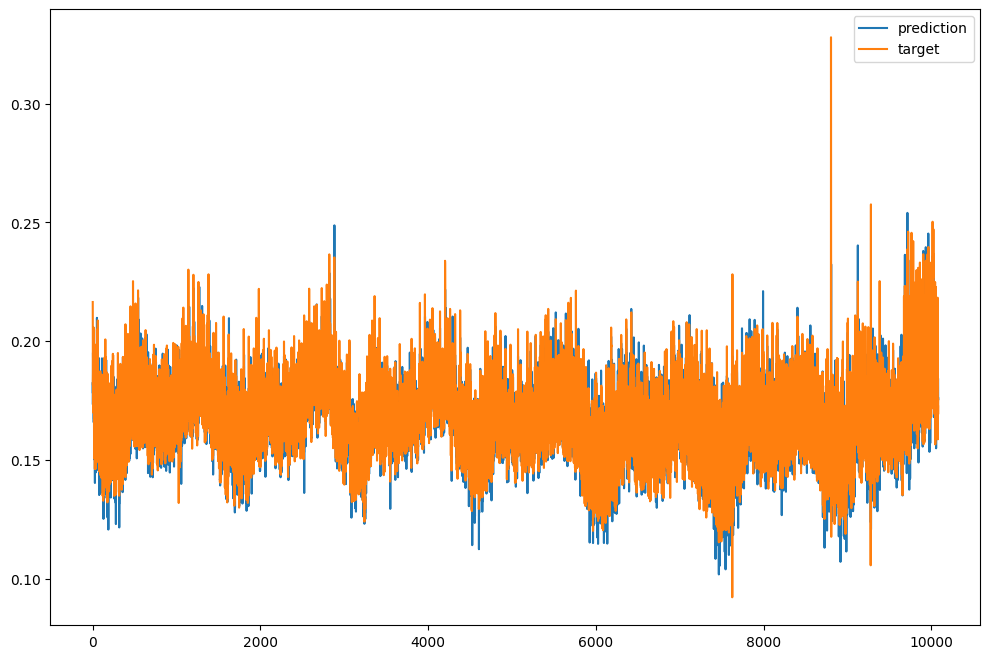

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.17377418, 0.18270507, 0.17812276, ..., 0.1843628 , 0.17520119,
       0.17598046])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.850669786334038 %
RMSE 0.009051376022398472
MAPE 3.8517631590366364 %


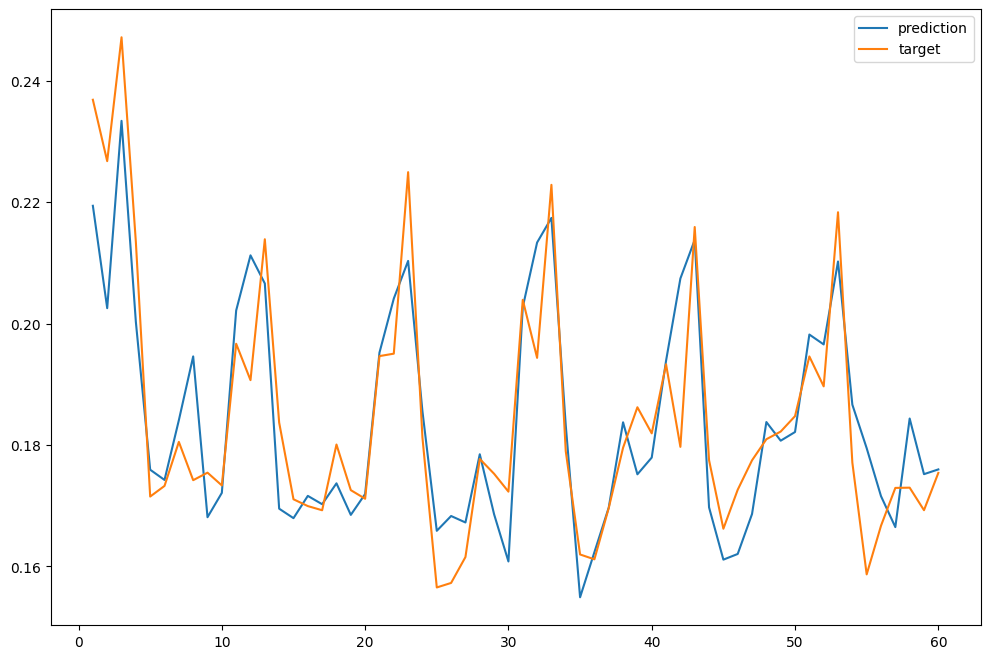

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.32295251512338247